In [15]:
import functools
import itertools
import pathlib

import hg
import ipywidgets
import jscatter
import matplotlib.colors as colors
import pandas as pd
import traitlets
import traittypes
import tweakpane


def load_eigs_and_clusters(stages: tuple[str], data_dir: pathlib.Path):
    eigs = []
    for name in stages:
        eigs_path = (
            data_dir
            / f"eigvecs.proj__ESC-Trypsin-FA-DSG-HindIII.{name}-Trypsin-FA-DSG-HindIII.E1-E10.hg38.50000.pq"
        )
        eigs_df = pd.read_parquet(eigs_path).dropna()
        eigs.append(eigs_df)

    # create shared index for all dataframes
    index = functools.reduce(pd.Index.intersection, [df.index for df in eigs])

    return [df.loc[index] for df in eigs]


def load_tracks(data_dir: pathlib.Path):
    tracks = pd.read_parquet(data_dir / "tracks.hg38.50000.pq")
    clusters = pd.read_parquet(
        data_dir
        / "clusters.joint.proj__ESC-Trypsin-FA-DSG-HindIII.E1-E10.50000.kmeans_sm.pq"
    ).filter(regex="^kmeans_sm\d+$")
    for col in clusters:
        clusters[col] = clusters[col].astype(str)
    config = {
        "GC": dict(norm=colors.Normalize(vmin=0.35, vmax=0.65), map="RdYlBu_r"),
        "centel_abs": dict(norm=colors.Normalize(vmin=0, vmax=149043529), map="Greys"),
    }
    return tracks.join(clusters), config


def run(
    stages: tuple[str] = ("ESC", "DE", "HB", "iHEP", "mHEP"),
    x: str = "E1",
    y: str = "E2",
    data_dir: pathlib.Path = pathlib.Path.cwd() / "data",
):
    eigs = load_eigs_and_clusters(stages, data_dir)
    scatters = [jscatter.Scatter(x=x, y=y, data=data, opacity=0.5) for data in eigs]
    tracks, color_config = load_tracks(data_dir)

    src = scatters[0]
    for target in scatters[1:]:
        ipywidgets.jslink((src.widget, "selection"), (target.widget, "selection"))

    cols = [f"E{i}" for i in range(1, 11)]

    pane = tweakpane.Pane()
    pane.add_input("x", x, options=dict(zip(cols, cols)))
    pane.add_input("y", y, options=dict(zip(cols, cols)))
    pane.add_input(
        "color",
        "GC",
        options={name: name for name in tracks.columns if name not in ["start", "end"]},
    )

    def on_change_x(change):
        for scatter in scatters:
            scatter.x(change.new)

    def on_change_y(change):
        for scatter in scatters:
            scatter.y(change.new)

    def on_color_change(change):
        field = change["new"]
        for scatter in scatters:
            track_data = tracks.loc[scatter._data.index]
            scatter._data["_color"] = track_data[field]
            color_kwargs = color_config.get(field)
            if color_kwargs is None:
                color_kwargs = {}
                if scatter._data["_color"].dtype.name in ("object", "category"):
                    scatter._data["_color"] = scatter._data["_color"].astype(
                        "category"
                    )  # ensure categorical
                    color_kwargs["map"] = dict(
                        zip(
                            scatter._data["_color"].cat.categories,
                            jscatter.glasbey_dark,
                        )
                    )
                else:
                    color_kwargs["norm"] = colors.Normalize(
                        vmin=scatter._data["_color"].min(),
                        vmax=scatter._data["_color"].max(),
                    )
                    color_kwargs["map"] = "viridis_r"
            scatter.color(by="_color", **color_kwargs)

    pane.observe(on_change_x, names=["x"])
    pane.observe(on_change_y, names=["y"])
    pane.observe(on_color_change, names=["color"])
    on_color_change(dict(new="GC"))

    grid = ipywidgets.GridspecLayout(1, 6)
    grid[0, 0] = pane

    for name, scatter, (i, j) in zip(
        stages,
        scatters,
        itertools.islice(
            itertools.product(range(grid.n_rows), range(grid.n_columns)), 1, None
        ),
    ):
        grid[i, j] = ipywidgets.VBox([ipywidgets.Label(name), scatter.show()])

    grid.add_traits(
        selection=traittypes.Array([]),
        x=traitlets.Unicode(x),
        y=traitlets.Unicode(y),
    )

    ipywidgets.dlink(
        source=(scatters[0].widget, "selection"),
        target=(grid, "selection"),
        transform=lambda ind: scatters[0]._data.iloc[ind].index,
    )

    return grid


grid = run()
grid

GridspecLayout(children=(Pane(layout=Layout(grid_area='widget001')), VBox(children=(Label(value='ESC'), HBox(c…

In [17]:
out

Output()

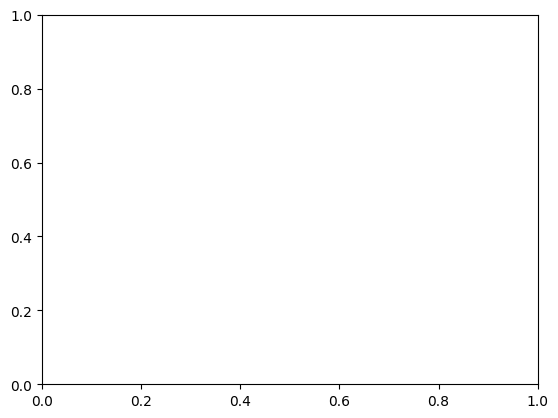

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display
import ipywidgets

out = ipywidgets.Output()
rna = pd.read_parquet("./data/tracks.hg38.50000.pq").filter(regex="R1.fwd$")

fig = plt.figure()
ax = plt.subplot(111)

@out.capture(clear_output=True)
def on_grid_selection_change(change):
    try:
        ax.clear()
        sns.violinplot(x="variable", y="value", data=np.log10(rna.loc[change.new] + 1).melt(), ax=ax)
        with out:
            display(fig)
    except Exception as e:
        with out:
            print(e)

grid.observe(on_grid_selection_change, names=["selection"])